# CS427 Autonomous Mobile Robotics – Assignment 2
# Sensors and Perception
#### Lecturer: Dr. John McDonald
#### Teaching Assistants: Saravanabalagi Ramachandran, Louis Gallagher

## Introduction

The aim of this assignment to provide you with some hands-on experience in applying some of the 3D visual perception techniques covered during the lectures. Before you start the assignment you should first review the associated lectures, notes, and recommended reading. 

#### Learning Outcomes
Once you have completed is that you should be able to :
- load images, detect features, and visualise those features in a python notebook,
- understand and manipulate the SIFT keypont data structure returned by OpenCV's SIFT interface,
- use the FLANN interface for robust key point matching across views,
- implement the basic 8-point algorithm to estimate the essential matrix,
- use the essential matrix to compute the epipolar geometry and rectify image pairs, and finally,
- compute dense disparity and depth maps

#### Assignment Setup and Useful Resources
Given that CS422 is a prerequisite to CS427 we do assume that everyone has some experience with python. However in case you need a refresher, or don't have the requisite expereience, a very good online tutorial is available at: [https://scipy-lectures.github.io/](https://scipy-lectures.github.io/). In particular we would recommend you take some time to go through the first two chapters, providing and intro to python, the third chapter, providing an overview of using numpy, and possibly the fourth chapter on plotting data. 

#### Completing the assignment and submitting your work

If you're reading this as a python notebook, then you already have everthing setup and ready to go! In order to complete the assignment you should simply work down through the notebook, adding and completing each of the identified code sections. Once you have completed all section you should save your notebook to disk and **upload the resulting .ipynb file through the moodle assignment link**.

#### Communication & Plagiarism Policy ##
As with the previous assignment, as you work through the problem set and the related lecture and reading material you are encouraged to use the CS427 Microsoft Teams group, or direct email with [John McDonald](mailto:John.McDonald@mu.ie) to post and discuss any questions that you have.

However, it is important to note that given that this work will count towards your final mark, the University Plagiarism Policy strictly applies to the assignment. In support of this policy and in order to maintain the integrity of the assessment process, individual students may be required to attend an online interview to discuss, explain, and validate their submission. 

#### Tasks and Marking Scheme
The assignment is worth 17% overall with the following mark breakdown for each subsection

**Exercise 1.** Complete the `draw_keypoints` code [10 marks]  
**Exercise 2.** SIFT feature  matching [10 marks]  
**Exercise 3.** RANSAC based essential matrix estimation [30 marks]  
**Exercise 4.** Visualising epipolar lines [5 marks]  
**Exercise 5.** Computing Dense Disparity and Depth Maps [5 marks]

## Part 0: Preliminaries
Here we import necessary packages that will be used throughout the notebook

In [1]:
from imshowtools import cvshow, imshow
import numpy as np
import cv2
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Part 1: Feature Detection and Matching

Features can be defined as an "interesting" region of an image which can be specific structures in the image such as points, corners, blobs, edges or objects which can help us in solving computer vision and robot perception tasks. As such, as a first step we need to be able to automatically locate and describe these "interesting" points in images so we can used them to identify correspondence and estimate the motion of the camera.

To start we will load a pair of images from the disk and display them side by side. We can use `imshow` from [imshowtools](https://github.com/saravanabalagi/imshowtools) library to do so.

Remember OpenCV reads images as BGR format. Here we need to change the image channel order to RGB before displaying. This cell shows the use of the `cvshow`, a convenience function which does this behind the scenes.

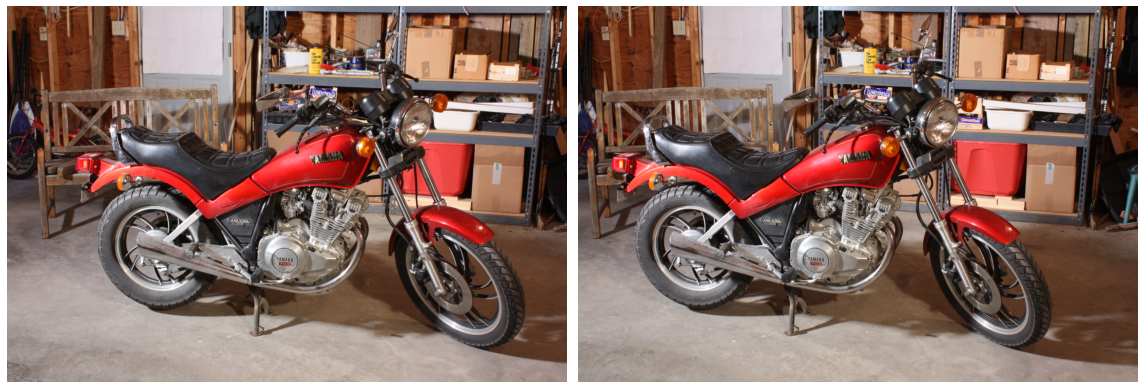

In [2]:
# Load Middlebury Data
K = np.array([3997.684, 0, 3997.684, 0, 1176.728, 1011.728, 0, 0, 1]).reshape((3,3)).astype(np.float32)
image_1 = cv2.imread('./images_middlebury/im0.png')
image_2 = cv2.imread('./images_middlebury/im1.png')

cvshow(image_1, image_2, size=(16,16))

### SIFT Features
During the lectures you will have seen the [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) feature detection and description algorithm. SIFT was published in ICCV by David G. Lowe with title "Object Recognition from Local Scale-Invariant Features" in 1999. The SIFT features are local and based on the appearance of the object at particular interest points, and are invariant to image scale and rotation. They are also robust to changes in illumination, noise, and minor changes in viewpoint. In addition to these properties, they are highly distinctive, relatively easy to extract and allow for correct object identification with low probability of mismatch. Each feature is described by a 128-d vector called the feature descriptor. You can read more about it in the paper [here](https://www.cs.ubc.ca/~lowe/papers/iccv99.pdf).


### Detect and compute SIFT features
You can find out more information about OpenCV's SIFT implementation [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) and the associated API [here](https://docs.opencv.org/trunk/d2/d29/classcv_1_1KeyPoint.html). The API provides two methods for SIFT detection, ```detect()``` and ```detectAndCompute()```. The former detects keypoints locations, scales and orientations. The latter both detects keypoints, and computes the associated descriptors. 

The output of theses methods are python lists. Keypoints are returned as a list of OpenCV [```KeyPoint```](https://docs.opencv.org/trunk/d2/d29/classcv_1_1KeyPoint.html) structures, whereas, descriptors are returned as a numpy matrix where each row stores a 128 dimensional SIFT feature.

Once you have installed SIFT you can use the following code to detect the SIFT features in each of the images you loaded above.

In [3]:
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

print(f"No. of keypoints in image_1: {len(keypoints_1)}")
print(f"No. of keypoints in image_2: {len(keypoints_2)}")
print(f"Shape of descriptors: {[descriptors_1.shape, descriptors_2.shape]}")

No. of keypoints in image_1: 11761
No. of keypoints in image_2: 11928
Shape of descriptors: [(11761, 128), (11928, 128)]


OpenCV provides a [```drawKeypoints```](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433) helper method to visualise detected keypoints.

The code below demonstrates the use of ```drawKeypoints```

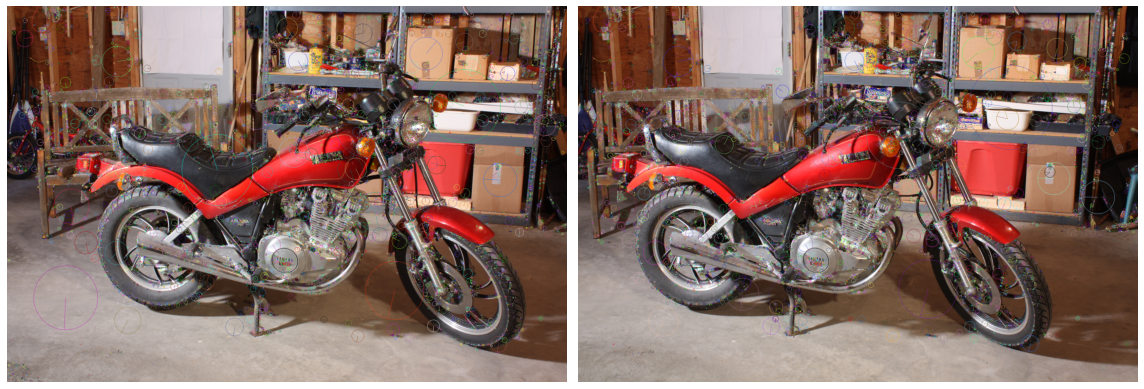

In [4]:
image_1_kp = cv2.drawKeypoints(image_1, keypoints_1, image_1.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_2_kp = cv2.drawKeypoints(image_2, keypoints_2, image_2.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cvshow(image_1_kp, image_2_kp, size=(16, 16))

**Exercise 1: In order to demonstrate your understanding of the keypoint data-structure complete the code in the cell below to mirror the functionality of the drawKeypoints method. The method should take as input an image and a set of keypoint points, draws the keypoints on the image and returns the result.**

The image below shows the meaning of each of the variables in the function:

![sift](https://imgur.com/c60ksdg.png)

The subsequent cell shows how the code should be called.

In [5]:
def draw_keypoints(image, keypoints):
    ''' draw the keypoints returned from OpenCV's detect function
    on the image
    '''
    # You can change these values here if the keypoints are
    # difficult to see in the resultant image
    thickness = 10
    alpha = 0.6
    
    # Opencv does not draw transparent circles on images
    # so we use a hack where we draw circles on a duplicate image
    # and overlay it on top with transparency
    overlay = image.copy()
    
    for keypoint in keypoints:
        
        # we need to draw a radius of length `radius` that is inclined with an angle `theta`
        # with (x, y) as centre of the circle. Compute (x, y), radius and theta. 
        x = int(keypoint.pt[0]) ## STEP 1: assign the x coord of keypoint (note you should cast it to type int)
        y = int(keypoint.pt[1]) ## STEP 2: assign the y coord of keypoint (note you should cast it to type int)
        
        radius = (keypoint.size)/2 ## STEP 3: assign the radius of keypoint (note in the keypoint structure the size store the diameter)
        theta = np.deg2rad(keypoint.angle) ## STEP 4: assign the angle in radians (in keypoint it's stored in degrees)
        
        # now that we have (x, y), radius and theta,
        # viz ...  starting_point, length and angle
        # find the endpoint (x2, y2)
        x2 = int(x + (radius * np.cos(theta))) ## STEP 5: assign x2 
        y2 = int(y + (radius * np.sin(theta))) ## STEP 6: assign y2
        
        # draw circles and lines using a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.circle(overlay, (x,y), int(radius), color, thickness)
        cv2.line(overlay, (x, y), (x2, y2), color, thickness)
        
    # overlay with alpha on original images, the images with circles on it
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    
    return image

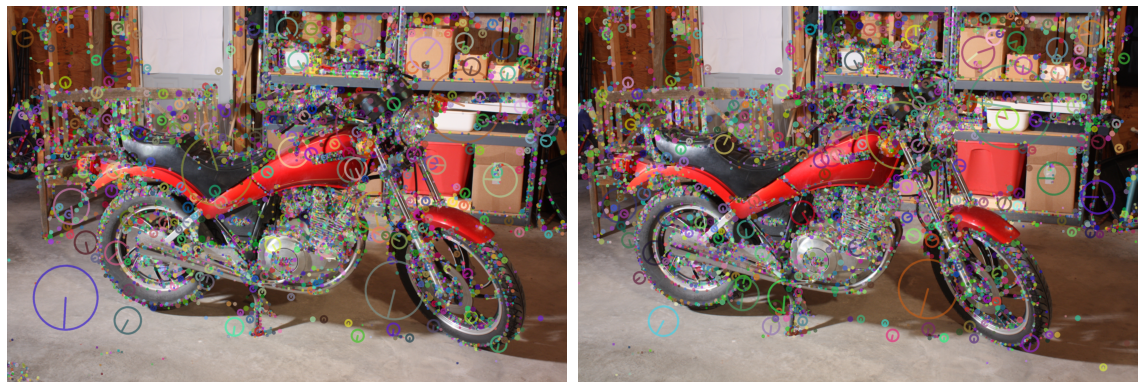

In [6]:
image_1_kp = draw_keypoints(image_1.copy(), keypoints_1)
image_2_kp = draw_keypoints(image_2.copy(), keypoints_2)
cvshow(image_1_kp, image_2_kp, size=(16, 16))

### SIFT Feature Matching

Feature descriptors like SIFT and [SURF](https://en.wikipedia.org/wiki/Speeded_up_robust_features) are usually compared and matched using the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) (think `L2_norm(feature_1 - feature_2)`). 

We can find the best match by comparing every feature with every other feature and pick the best match with the minimum distance. In this step, we use the descriptors to computer features matches (i.e. potential correspondences) between the pairs of images. Fill in the definition of the `get_matches_brute_force` functions below such that it returns a list of tuples (m, n), where each tuple represents a correspondence between feature m in descriptors_1 and feature n in descriptors_2. Hint: Use OpenCV's inbuilt `BFMatcher`

In [7]:
def get_matches_brute_force(descriptors_1, descriptors_2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
    return matches

In [8]:
matches = get_matches_brute_force(descriptors_1, descriptors_2)

This brute force matching would take $O(n^2)$ time to find all matches, and for each _leaf_ calculation we need to calculate the distance which depends on the number of dimensions for each feature. 

An alternative matcher, FLANN Matcher is an [Approximate Nearest Neighbour](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Approximate_nearest_neighbor) algorithm builds an efficient data structure known as a [KD-Tree](https://en.wikipedia.org/wiki/K-d_tree), that will be used to search for an approximate neighbour, while Brute Force Matcher does an exhaustive search as explained before and is guaranteed to find the best neighbour. For larger datasets with high dimensional features, such as ours with shape $ 2 \times ~11k \times 128 $, it is efficient to trade-off a small percentage of accuracy for time. You can play with FLANN's parameters in order to increase the precision (i.e. the _quality_ of the matchings), but at the cost of slowing the algorithm.

**Exercise 2a: Fill in the definition of the `get_matches_flann`. Hint: Use OpenCV's inbuilt `FlannBasedMatcher`**

In [9]:
def get_matches_flann(descriptors_1, descriptors_2):
    ## Review the OpenCV documentation related to FlannBasedMatcher 
    ## and provide an implementation of this function
    index_params = dict(algorithm = 0, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descriptors_1, descriptors_2,2)
    return matches

You can use `%%time` on the first line of any cell to find out how much time it takes for execution. See example below:

In [10]:
%%time
matches = get_matches_flann(descriptors_1, descriptors_2)

Wall time: 8.09 s


### Eliminating bad matches

Now that we have matches, let's eliminate bad matches. As you have seen during lectures, two possible approaches are (i) to threshold the distance, and (ii) to apply the ratio test. You should review both of these approaches in the lecture material.

The result of the FLANN matcher is the python list called `matches`, where each element of the list contains two `DMatch` structures. The first is the best match, and the second is the second best match. You can find details on the `DMatch` structure [here](https://docs.opencv.org/3.4/d4/de0/classcv_1_1DMatch.html).

**Exercise 2b: Use ratio test proposed by D.Lowe in SIFT paper, i.e. eliminate any matched pair (m, n) if m.distance is greater than 70% of n.distance**

In [11]:
## Add code here to complete Exercise 2b ## 
good_matches = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append([m,n])

### Visualising Good Matches
Draw the good matches on image to visualize how the features match

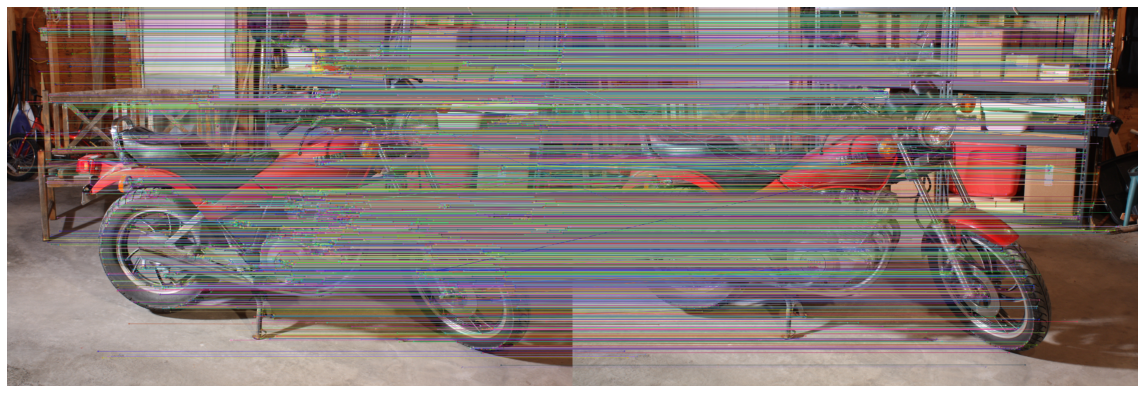

In [12]:
image_matches = cv2.drawMatches(image_1, keypoints_1,
                                image_2, keypoints_2,
                                [m for (m, n) in good_matches], None, flags=2)
cvshow(image_matches, size=(16, 16))

Now that we have good matches, let's leave out the bad points in `keypoints_1` and `keypoints_2`.

Build `points_matched_1` and `points_matched_1` such that
- they contain only good matches
- they are aligned. i.e. `points_matched_2[i]` should contain matching keypoint for `points_matched_1[i]`

In [13]:
points_matched_1 = np.array([keypoints_1[m.queryIdx].pt for m, n in good_matches], dtype=int)
points_matched_2 = np.array([keypoints_2[m.trainIdx].pt for m, n in good_matches], dtype=int)

### Computing the Essential Matrix

In this section you will learn how to use the filtered SIFT feature correspondences computed above to compute the Essential Matrix, $\mathbf{E}$, relating the two views of the scene. As presented in the course lectures, the essential matrix is an linear operator that performs a [linear transformations](https://en.wikipedia.org/wiki/Matrix_(mathematics)#Linear_transformations) between the two views, relating points in one view to points in the other view. 

More specifically, the [Essential Matrix](https://en.wikipedia.org/wiki/Essential_matrix) $\mathbf{E}$, maps a (homogeneous) point, $\mathbf{p}$, in one image to an epi-polar line (or epiline), $\mathbf{l}'$, in the other image. The significance of $\mathbf{l}'$ is that it contains the corresponding point, $\mathbf{p}'$. As we have seen in lecutres, one approach to computing $\mathbf{E}$ is to identify a set of corresponding points from both images, where a minimum of 8 such points are required, and then applying the 8-point algorithm (hence the name). 

Given noise in the feature detection and matching process, in general we will use much more than 8 points and use an algorithm knowan as RANSAC to get a more robust result (see RANSAC section below).

One further point to note is that the essential matrix assumes that both cameras have been calibrated. Although not covered during lectures, if you are doing further research online, searches related to the essential matrix may lead you to discussions on the [Fundamental Matrix](https://en.wikipedia.org/wiki/Fundamental_matrix_(computer_vision)), $\mathbf{F}$, which is analgous to the essential matrix in that they both transform points from one image to lines on the other:
$${\mathbf  {p}_r}^{{\top }}{\mathbf  {Fp}_l}=0$$
$${\mathbf  {p}_r}'^{\top }\,{\mathbf  {E}}\,{\mathbf  {p}_{l}}'=0$$
but notice that $\mathbf{p}'_r$ and $\mathbf{p}'_l$ are points in [normalized image coordinates](https://en.wikipedia.org/wiki/Camera_matrix#Normalized_camera_matrix_and_normalized_image_coordinates), whereas $\mathbf{p}_r$ and $\mathbf{p}_l$ are points in the camera image. 

The Fundamental Matrix, $\mathbf{F}$, and Essential Matrix, $\mathbf{E}$ are related by 
$$ \mathbf {E} ={\mathbf {K}}^{\top }\;\mathbf {F} \;\mathbf {K} $$ or,
$$ \mathbf {F} ={\mathbf {K^{-1}}}^{\top }\;\mathbf {E} \;\mathbf {K^{-1}} $$
where we assume that both camera's have the same intrinsic calibration matrices, $\mathbf {K}$. 

### Computing the Essential Matrix with OpenCV
Similar to the approach we took with SIFT feature visualisation, in this section you will first use the built-in OpenCV function to determine the Essential Matrix using `points_matched_1` and `points_matched_2`.

To do this you should read the documentation on [`findEssentialMat`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga13f7e34de8fa516a686a56af1196247f). 

In [14]:
E_ref, mask_ref = cv2.findEssentialMat(points_matched_1, points_matched_2, K, cv2.RANSAC)
E_ref = E_ref / E_ref[2,2]
E_ref, sum(mask_ref)


(array([[-8.25492818e-04,  8.25411372e+00,  8.24898983e-01],
        [-8.64969397e+00,  9.99761962e-01,  1.07268188e+03],
        [-7.65290725e-01, -1.07268505e+03,  1.00000000e+00]]),
 array([229], dtype=uint8))

### Random Sample Consensus (RANSAC)
The rationale for using more than 8-points in the estimation of the Essential matrix is to provide an optimal estimate given that the data will be affected by noise. The technique we apply is known as Least-Squares Estimation and is optimal in the context of Gaussian noise. However the problem is that as we have seen with the feature matching, inevitably some matches will be incorrect correspondences known as *outliers*. Such outliers do not fit this Gaussianity assumption of Least Squares, and as such can have a detrimental effect on the estimation process.

To overcome this problem we use an algorithm known as [Random Sample Consensus (RANSAC)](https://en.wikipedia.org/wiki/Random_sample_consensus) developed by [Fishler and Bowles in 1980](https://apps.dtic.mil/dtic/tr/fulltext/u2/a460585.pdf). The algorithm first segments the data into inliers and outliers, and then applies least-squares to the resulting inliers. 

A pseudo-code algorithm for applying RANSAC to estimate the essential matrix from a group of correspondences is shown below. (Note: you will find different variants of the algorithm online).

```
Parameters:
N = maximum number of iterations
M = required number of inliers to accept a model
T = tolerance threshold on deciding if a point is an inlier 

k=0
proposed_models=[]
while (k < N)
    select 8 correspondences at random
    estimate a proposed essential matrix, E' from the selected correspondences
    inlier_count = number of correspondences that agree with E' within the threshold T
    added (E,inlier_count) to proposed models
    
select and return E with highest inlier_count from proposed_models
```

## Developing your own RANSAC based Essential Matrix Estimation

In this section you will be given some template code where each cell provides an incomplete implementation a different component of the overall RANSAC based essential matrix estimation.

The `eigth_point_algorithm` function below provides the core estimation algorithm given two sets of corresponding points (i.e. it assumes not outliers). The function should first construct the constraint matrix and then use numerical optimsation techniques to estimate $\mathbf{E}$. The numerical optimsation code has been provided, however the code to complete the constraint matrix is incomplete.

**Exercise 3a: Complete the function by replacing the comment with the code to construct the constraint matrix**

In [15]:
def eigth_point_algorithm(x1, x2):
    """
    x1: param contains the 8-points from the left image
    x2: param contains the 8 corresponding points in the right image
    
    """
    ## TODO: Add the necessary code here to compute the A matrix of 
    ## constraints for the 8 point algorithm
    ## Be careful to get the ordering of the left and
    ## right points correct when constructing the constraint rows. 
    ## Review the online lecture, notes, etc. if
    ## you have any difficulties
    A = np.zeros((x1.shape[1], 9))
      
    for i in range(x1.shape[1]):
        A[i] = [x1[0, i] * x2[0, i],  x1[0, i] * x2[1, i],  x1[0, i] * x2[2, i],
                x1[1, i] * x2[0, i],  x1[1, i] * x2[1, i],  x1[1, i] * x2[2, i],
                x1[2, i] * x2[0, i],  x1[2, i] * x2[1, i],  x1[2, i] * x2[2, i],
               ]

    # The code below will take your A matrix and compute
    # the corresponding Essential matrix
    U,S,V = np.linalg.svd(A)
    E = V[-1].reshape(3,3)
    
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(E)
    S[2] = 0
    E = np.dot(U, np.dot(np.diag(S), V))
    
    # Keep the last element 1, 
    # divide the whole matrix by that element
    return E / E[2,2]

Hartley proposed [normalized eight point algorihtm](https://en.wikipedia.org/wiki/Eight-point_algorithm#The_normalized_eight-point_algorithm) where the coordinate system of each of the two images should be transformed, independently, into a new coordinate system according to the following principle.
- The origin of the new coordinate system should be centered (have its origin) at the centroid (center of gravity) of the image points. This is accomplished by a translation of the original origin to the new one.
- After the translation the coordinates are uniformly scaled so that the mean distance from the origin to a point equals $\sqrt {2} $

The function below implements this algorithm and is used in the overall pipeline. However **it is not necessary for you to understand or alter this algorithm and code**. With this said feel free to review and ask any questions you have about it in case you are interested.

In [16]:
def eigth_point_algorithm_normalized(x1, x2):
    """
    First proposed by Richard Hartley 1997 in "In Defence of the 8-point Algorithm"
    For neat equations, see equation (10) in Chojnacki et al 2003
    Revisiting Hartley’s Normalized Eight-Point Algorithm
    https://cs.adelaide.edu.au/~wojtek/papers/pami-nals2.pdf
    """
    
    # compute T1
    x1 = x1 / x1[:, 2][:, None]
    mean_1 = np.mean(x1[:, :2], axis=0)
    s1 = np.sqrt(2) / np.std(x1[:, :2])
    T1 = np.array([[s1,   0,  -s1*mean_1[0]],
                   [ 0,  s1,  -s1*mean_1[1]],
                   [ 0,   0,             1]])

    
    # compute T2
    x2 = x2 / x2[:, 2][:, None]
    mean_2 = np.mean(x2[:, :2], axis=0)
    s2 = np.sqrt(2) / np.std(x2[:, :2])
    T2 = np.array([[s2,   0,  -s2*mean_2[0]],
                   [ 0,  s2,  -s2*mean_2[1]],
                   [ 0,   0,             1]])
    
    # normalize x1 and x2
    # Shapes: T(3, 3), x(n, 3)
    # After Transpose: T(3, 3), x(3, n)
    # Result = (3, n)
    # Result Transpose: (n, 3)
    x1 = np.dot(T1, x1.T).T
    x2 = np.dot(T2, x2.T).T
    
    # Find E using eigth_point_algorithm
    E = eigth_point_algorithm(x1, x2)
    
    # unnormalized E = T2' (E T1)
    E = np.dot(T2.T, np.dot(E, T1))
    
    # Keep the last element 1, 
    # divide the whole matrix by that element
    return E / E[2,2]

### Lines in homogeneous coordinates
In homogeneous coordinates a line can be written as $$ax+by+cw=0$$
or in vector form $$\left[\begin{array}{c} a & b & c \end{array}\right]\left[\begin{array}{c} x \\\ y \\\ w \end{array}\right]=0$$
If we write $\mathbf{l}=\left[\begin{array}{c} a \\\ b \\\ c \end{array}\right]$ and $\mathbf{p}=\left[\begin{array}{c} x \\\ y \\\ w \end{array}\right]$ we can write this is a more compact notation as: $\mathbf{l}^{T}\mathbf{p}=0$
or, given that the inner product is commutative, $\mathbf{p}^{T}\mathbf{l}=0$

### Epilines from the Essential matrix
Now remember that the epipolar constraint for a pair of points is given by $$\mathbf{p}_{r}'^{\top}\mathbf{Ep}_{l}'=0$$
We can see here that if we let $\mathbf{l}_{l}^{\top}=(\mathbf{p}_{r}'^{\top}\mathbf{E})$, then we can define the epiline in the left image as: $$\mathbf{l}_{l}^{\top}\mathbf{p'}_{l}=0$$
Similarly, if we let $\mathbf{l}_{r}=(\mathbf{Ep'}_{l})$, then we can define the epiline in the left image as: $$\mathbf{p'}_{r}^{\top}\mathbf{l}_{r}=\mathbf{l}_{r}^{\top}\mathbf{p'}_{r}=0$$

### Finding inliers
Using the above, we will now move onto the next element of the RANSAC implementation which is to identify the number of inliers for a proposed model. The two cells below provide a `point_line_distance` function and a partial implementation of `find_inliers`.

`point_line_distance` takes as input two vectors, where the first is the homogeneous coordinates of the line (i.e. as explained above), and the second is a two-element inhomogeneous coordinates of a point. The function returns the perpendicular distance between the line and the point.

`find_inliers(E, keypoints_1, keypoints_2, threshold)` takes as input a proposed essential matrix, a set of right image keypoints, a set of left image keypoints, and a threshold distance to decide whether a point is an inlier or outlier i.e. any point within a distance of `threshold` to its corresponding epiline is considered an inlier. The approach taken by the function is to iterate through every pair of keypoints, compute the parameters for the left and right epiline, and then compute the error between each point and its corresponding epiline. Finally we append a value of `True` or `False` to the mask array to mark the point as an inlier or outlier. This array is then returned by the function.

**Exercise 3b: Complete the definition of `find_inliers` by replacing the comment label `TODO` with the appropriate lines of code**

In [17]:
def point_line_distance(line, point):
    a, b, c = line
    u, v = point
    return abs((a*u + b*v + c) / np.sqrt(a ** 2 + b ** 2))

In [18]:
def find_inliers(F, keypoints_1, keypoints_2, threshold=10):
    mask = []
    
    ## The zip function here takes two list and creates a new iteratable zip object
    ## where on each iteration keypoint_1 and keypoint_2 will be two keypoints
    for keypoint_1, keypoint_2 in zip(keypoints_1, keypoints_2):
        # Compute the parameters of the epilines in each image
        
        ## TODO: ADD CODE HERE TO COMPUTE line_1 and line_2 ##
        ##       EACH OF WHICH SHOULD BE A VECTOR OF 3 LINE ##
        ##       PARAMETERS                                 ##
        keypoint_1_padded = np.zeros((1,3), int)
        keypoint_1_padded = np.append(keypoint_1, 1)
        keypoint_2_padded = np.zeros((1,3), int)
        keypoint_2_padded = np.append(keypoint_2, 1)
        line_1 = np.dot(keypoint_1_padded, F)
        line_2 = np.dot(F, keypoint_2_padded.T).T
        
        # Compute the error between the point and the epiline (i.e using point_line_distance)
        ## TODO: ADD CODE HERE TO COMPUTE THE DISTANCE BETWEEN ##
        ## EACH LINE AND THE CORRESPONDING POINT FROM THE OTHER##
        ## IMAGE. YOU SHOULD STORE THE VALUES IN TWO VARIABLES ##
        ## error_1 AND error_2 RESPECTIVELY                    ##
        error_1 = point_line_distance(line_1, keypoint_2)
        error_2 = point_line_distance(line_2, keypoint_1)
        
        error = np.sqrt(error_1**2 + error_2**2)
        
        passed = True if error < threshold else False
        mask.append([passed])
    return np.array(mask)

### RANSAC
Finally the function below provides a partial implementation of the RANSAC based essential matrix estimation as described in pseudo-code above.

The RANSAC loop runs for a fixed number of iterations (default: 100) and then returns the essential matrix with the maximum number of inliers. 

**Exercise 3c: Complete the definition of `find_essential_matrix` by replacing the comments label `STEP X` with the appropriate code**

**Specifically you are required to add code to:**
1. Covert the input points to their homogeneous representation
2. Compute the normalised coordinates for each point. This is required because remember that the essential matrix relates normalised views.
3. Randomly select 8 correspondences within the RANSAC loop
4. Comment the function


In [19]:
def get_F(K_inv, E):
    return np.dot(K_inv.T, np.dot(E, K_inv))

In [20]:
## STEP 4: FIRST COMPLETE STEPS 1-3 BELOW. NOW REVIEW THE RANSAC   ##
## PSEUDO CODE ALGORITHM IN THE CORRESPONDING SECTION ABOVE. ADD   ##
## COMMENTS TO THE APPROPRIATE LINES OF THIS FUNCTION TO INDENTIFY ##
## WHICH PARTS OF THE PSEUDO CODE ALGORITHM CORRESPOND TO THE      ##
## LINES OF CODE IN THE FUNCTION                                   ##

def find_essential_matrix(keypoints_1, keypoints_2, K, ransac_iterations=100):
    num_inliers_list = []
    inliers_mask_list = []
    E_list = []
    K_inv = np.linalg.inv(K)
    
    # Shape (n, 2) -> (n, 3)
    ## STEP 1: ADD CODE HERE TO CONVERT EACH SET OF KEYPOINTS TO HOMOGENEOUS FORM  ##
    ## NOTE YOU SHOULD STORE THEM IN A SEPARATE VARIABLE NAME i.e. DON'T OVERWRITE ##
    ## keypoints_1 and keypoints_2                                                 ## 
    
    def convert_to_homogeneous(old):
        return np.pad(old, ((0, 0), (0, 1)), mode='constant', constant_values=1)
            
    homogeneous_1 = convert_to_homogeneous(keypoints_1)
    homogeneous_2 = convert_to_homogeneous(keypoints_2)
    
    # Normalize using K_inv to get normalized image coordinates
    ## STEP 2: ADD CODE HERE TO REPROJECT EACH SET OF HOMOGENEOUS KEYPOINTS ##
    ## TO NORMALISED COORDINATES.                                           ##
    
    homogeneous_1 = np.dot(homogeneous_1, K_inv)
    homogeneous_2 = np.dot(homogeneous_2, K_inv)
    
    # This for loop runs for ransac_iterations number of iterations
    # Wrapping range(ransac_iterations) in a tqdm object should result
    # in a progress bar being displayed as RANSAC progresses 
    for _ in tqdm(range(ransac_iterations)):
        
        ## STEP 3: ADD CODE HERE TO SELECT 8 CORRESPONDENCES AT RANDOM FROM ##
        ## THE NORMALISED COORDINATE VERSIONS OF THE KEYPOINTS YOU SHOULD   ##
        ## STORE THE SELECTED CORRESPONDENCES SUCH THAT THE POINTS FROM     ##
        ## THE FIRST IMAGE ARE IN keypoints_1_selected AND THE POINTS FROM  ##
        ## IMAGE TWO ARE STORED IN keypoints_2_selected                     ##
        ## HINT: FOR SELECTING ELEMENTS AT RANDOM YOU SHOULD TAKE A LOOK AT ##
        ## np.random.choice                                                 ##
        
        def get_random_eight(keypoints):
            np.random.shuffle(keypoints)
            return keypoints[:8,:]
        
        keypoints_1_selected = get_random_eight(homogeneous_1)
        keypoints_2_selected = get_random_eight(homogeneous_2)
        
        E = eigth_point_algorithm_normalized(keypoints_1_selected, keypoints_2_selected)
        F = get_F(K_inv, E)
        inliers_mask = find_inliers(F, keypoints_1, keypoints_2)
        
        E_list.append(E)
        inliers_mask_list.append(inliers_mask)
        num_inliers_list.append(np.sum(inliers_mask))

    best_index = num_inliers_list.index(max(num_inliers_list))
    best_E = E_list[best_index]
    best_E_inliers_mask = inliers_mask_list[best_index]
    return best_E, best_E_inliers_mask

In [21]:
E, mask = find_essential_matrix(points_matched_1, points_matched_2, K)
E, sum(mask)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([[ 6.50964327e+07, -1.68287527e+08, -1.66098934e+04],
        [ 5.54841176e+07,  3.84202797e+07,  4.90588765e+03],
        [ 4.41115379e+04,  2.87677746e+03,  1.00000000e+00]]),
 array([98]))

In [22]:
# for comparison
E_ref, sum(mask_ref)

(array([[-8.25492818e-04,  8.25411372e+00,  8.24898983e-01],
        [-8.64969397e+00,  9.99761962e-01,  1.07268188e+03],
        [-7.65290725e-01, -1.07268505e+03,  1.00000000e+00]]),
 array([229], dtype=uint8))

## Visualising the Epipolar Lines 
Over the next few section we will provide you with code for taking the essential matrix that you have estimated and visualising the resultant epipolar lines. For this code you do not have to alter anything, but you should read down through it, try to understand what's happening at each step, and add the comments to the code for **Exercise 4a**.

### Find Inlier Points
Get indices for inliers using `mask`. `inlier_indices` should be an array with same shape as that of `mask` and with value `True` or `False` dependending upon whether it's an inlier or an outlier.

In [23]:
inlier_indices = mask.ravel() == 1

Get only the inlier points using inlier indices

In [24]:
points_inlier_1 = points_matched_1[inlier_indices]
points_inlier_2 = points_matched_2[inlier_indices]

points_inlier_1.shape, points_inlier_2.shape

((98, 2), (98, 2))

### Compute Epipolar Lines
Here we wish to compute the epipolar lines using Essential Matrix as we learnt in 3.1 _8 point algorithm_ online lecture using the following equations $${\mathbf  {p}_r}'^{\top }\,{\mathbf  {E}}\,{\mathbf  {p}_{l}}'=0$$

However as mentioned in the section regarding the Fundamental matrix, since we want to use points directly from our original image, and draw the resulting lines onto those images, we can't use normalised coordinates. Intead we use the standard image coordinates and the fundamental matrix
$${\mathbf  {p}_r}^{{\top }}{\mathbf  {Fp}_l}=0$$

**Exercise 4a: Comment each line of code in the following two notebook cells**

In [25]:
def get_epipolar_lines_on_image_1(points_inlier_2, F):
    points_inlier_2_3dim = np.pad(points_inlier_2, ((0, 0), (0, 1)), mode='constant', constant_values=1) # pad each point with an extra one
    return np.dot(points_inlier_2_3dim, F) # get dot product of homogeneus inliers and the fundamental matrix

def get_epipolar_lines_on_image_2(points_inlier_1, F):
    points_inlier_1_3dim = np.pad(points_inlier_1, ((0, 0), (0, 1)), mode='constant', constant_values=1) # same as above
    return np.dot(F, points_inlier_1_3dim.T).T # same as above but with Transpose becuase it's for image two

In [26]:
F = get_F(np.linalg.inv(K),E) # get the fundamental matrix with the inverse of the image array K and the ssential matrix E
epipolar_lines_1 = get_epipolar_lines_on_image_1(points_inlier_2, F) # compute lines for image one with points from two and fundamental matrix
epipolar_lines_2 = get_epipolar_lines_on_image_2(points_inlier_1, F) # compute lines for image two with points from one and fundamental matrix

### Draw epipolar lines

In [27]:
def drawlines(image_1, image_2, lines, points_1, points_2):
    """
    Draw the epipolar lines on image_1 for the points in image_2
    :param image_1: Image on which epipolar lines should be drawn
    :param image_2: Image on which keypoints are computed
    :param lines: Epipolar lines of shape (<>, 3)
    :param points_1: Keypoints on image_1
    :param points_2: Keypoints on image_2
    :return: (image_1, image_2) where image_2 has keypoints and 
        image_1 has corresponding epipolar lines on it along with image_1 keypoints 
    """
    r, c = image_1.shape[:2]
    image_1_overlay = image_1.copy()
    image_2_overlay = image_2.copy()
    alpha_1 = 0.5
    alpha_2 = 0.7
    
    for r, point_1, point_2 in zip(lines, points_1, points_2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1] ])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(image_1_overlay, (x0, y0), (x1, y1), color, 3)
        cv2.circle(image_1_overlay, tuple(point_1), 15, color, 3)
        cv2.circle(image_2_overlay, tuple(point_2), 15, color, 3)
    
    image_1 = cv2.addWeighted(image_1_overlay, alpha_1, image_1, 1 - alpha_1, 0)
    image_2 = cv2.addWeighted(image_2_overlay, alpha_2, image_2, 1 - alpha_2, 0)
    return image_1, image_2

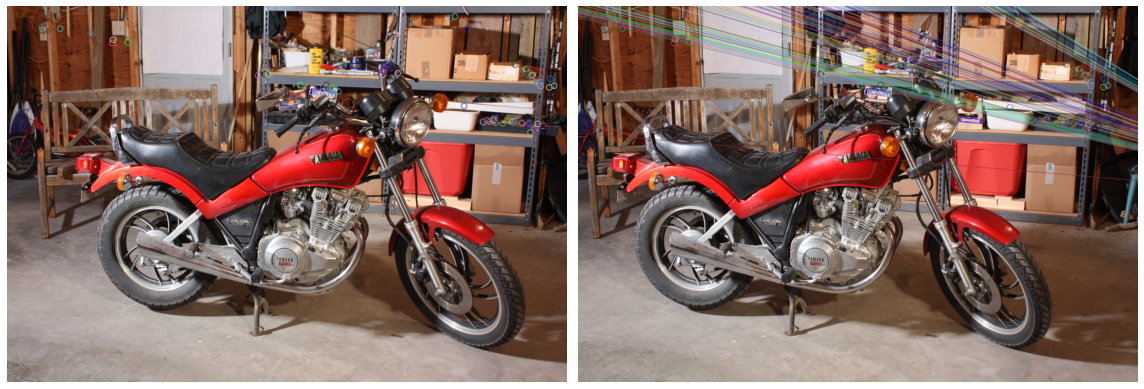

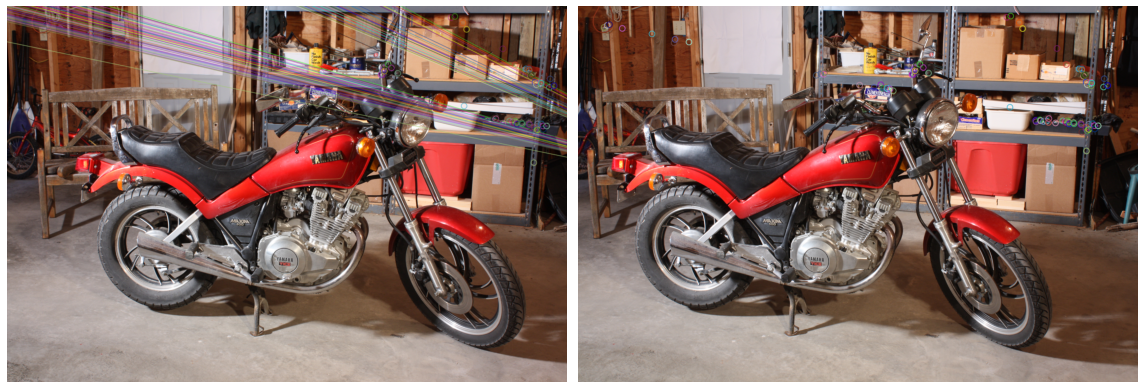

In [28]:
image_1_lines, image_2_points = drawlines(np.copy(image_1), np.copy(image_2), epipolar_lines_1, points_inlier_1, points_inlier_2)
image_2_lines, image_1_points = drawlines(np.copy(image_2), np.copy(image_1), epipolar_lines_2, points_inlier_2, points_inlier_1)

cvshow(image_1_points, image_2_lines, size=(16, 16))
cvshow(image_1_lines, image_2_points, size=(16, 16))

## Disparity and Depth Map

The code below computes a dense disparity map using OpenCV's stereo block matcher which computes a dense disparity map using a sum of absolute differences (SAD) matching algorithm.

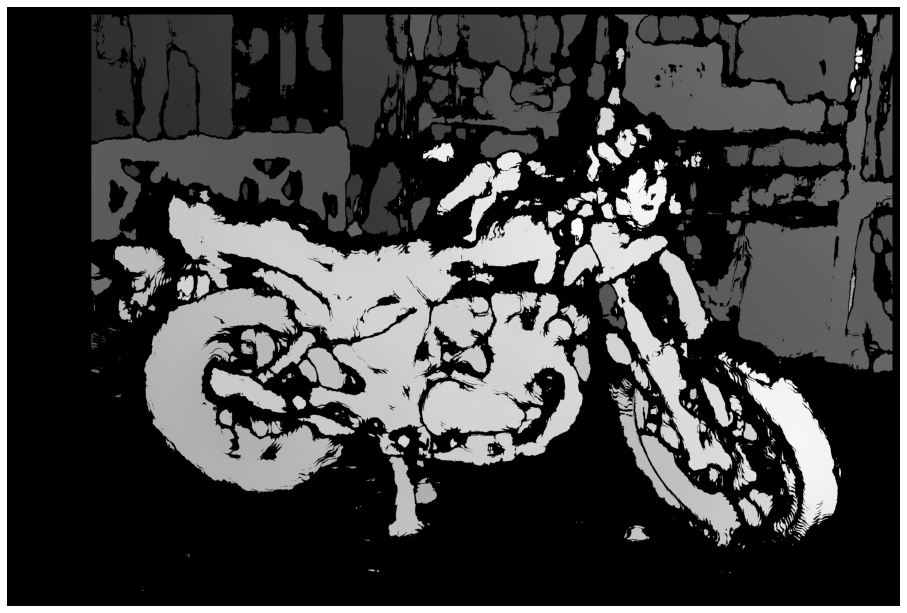

In [29]:
image_1_bw = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
image_2_bw = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
stereo = cv2.StereoBM_create(numDisparities=256, blockSize=51)
disparity = stereo.compute(image_1_bw, image_2_bw)
imshow(disparity, cmap='gray', size=(16, 16))

### Disparity Correction

Pixels of objects at infinite distance would show zero displacement (or a disparity value of 0) between the stereo pair. However, you might see min disparity is not after all 0, but -16 instead. StereoBM computes 16-bit fixed-point disparity map (where each disparity value has 4 fractional bits, and hence we divide by 16 before using it here. See [docs](https://docs.opencv.org/master/d2/d6e/classcv_1_1StereoMatcher.html#a03f7087df1b2c618462eb98898841345) for more info.

After the correction, you would see that the minimum disparity is -1. That's because these are the pixels where BlockMatcher could not compute the disparity. 

In [30]:
print(f"Before: {np.max(disparity), np.min(disparity)}")
corrected_disparity = disparity / 16
print(f"After: {np.max(corrected_disparity), np.min(corrected_disparity)}")

Before: (4080, -16)
After: (255.0, -1.0)


We then add a small epsilon (1e-3) to all values that are zero, to avoid divide by zero errors in the notebook below

In [31]:
zero_indices = np.where(corrected_disparity==0)
corrected_disparity[zero_indices] = 1e-3

### Computing the Depth Map

Here we set the baseline, i.e. distance of camera right w.r.t camera left reference, which we have taken directly from the Middlebury camera calibration params

In [32]:
baseline = 193.001

Here we compute the depth from diparity.

**Exercise 5a: Replace the comment in the cell below with the correct expression for converting the (corrected) disparity into a depth value i.e. you should use the values from  corrected_disparity variable and NOT the disparity image directly. (See the section of the notes on "3D Reconstruction from 2-views"**

In [33]:
focal_length = K[0,0]
depth = (baseline*focal_length)/corrected_disparity
depth = depth / 1000   # to m

Prepare to plot a smaller version of `depth` and `image_1`

In [34]:
small_size = (150, 75)
depth_small = cv2.resize(depth, small_size)
image_1_small = cv2.resize(image_1[:, :, ::-1], small_size)

In [35]:
row, col = np.indices(depth_small.shape)
row.shape, col.shape, depth_small.shape

((75, 150), (75, 150), (75, 150))

You can remove pixels for which we do not have depth, or you can choose to show them at `show_unmapped_pixels_at_depth`.

In [36]:
remove_background = True
show_unmapped_pixels_at_depth = 40

In [37]:
c = image_1_small.reshape(-1, 3)/255
c = np.pad(c, ((0,0), (0,1)), mode='constant', constant_values=1)

# for depth
d = depth_small.flatten()

if remove_background:
    # to remove background, we should hide the pixels for which we didn't have disparity
    # let's correct that and recalculate depth_small and then 
    # set color of those points to (0, 0, 0, 0) so they become invisible
    depth_corrected = depth.copy()
    depth_corrected[np.where(depth_corrected==-focal_length*baseline/1000)] = -1
    depth_small = cv2.resize(depth_corrected, small_size)
    d = depth_small.flatten()
    c[np.where(d==-1)] = 0
    
else:
    d[np.where(d==-1)] = show_unmapped_pixels_at_depth

### Plot image with depth map in 2.5D

We will now overlay the depth map on top of the image, and push each pixel using depth corresponding to that pixel.

With `%matplotlib notebook` for jupyter notebook or `%matplotlib widget` for jupyterlab, this plot will become interactive. (Interaction on remotely hosted jupyter servers will be poor). You can also adjust `ax.azim` and `ax.elev` (in degrees) values to change the viewpoint. Defaults are `ax.azim = -60` and `ax.elev = 30`

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

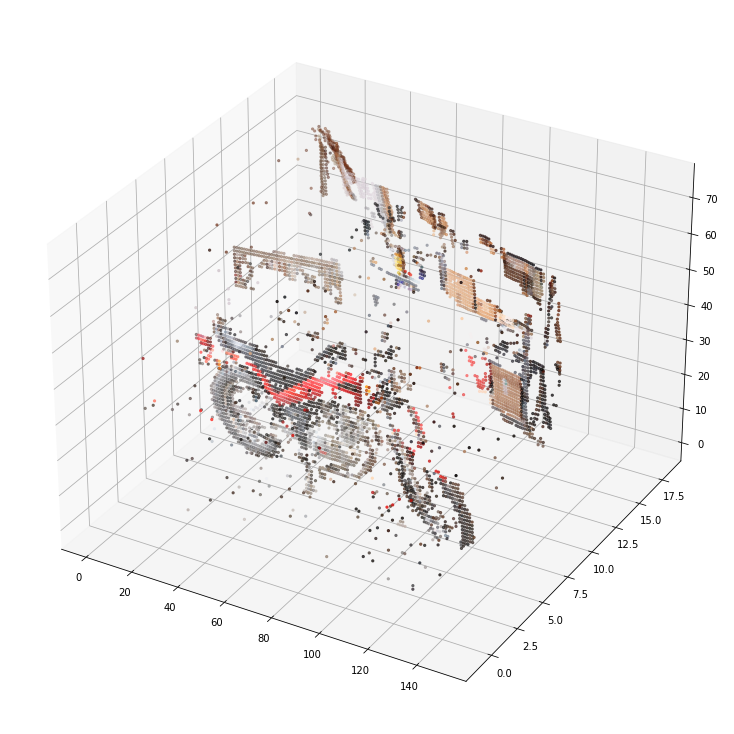

In [38]:
%matplotlib widget
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig)
ax.scatter(col[::-1], d, row[::-1], c=c, marker='.')
plt.show()